<a href="https://colab.research.google.com/github/aldadobi/-YOLOv8-Cell_Counting-training/blob/main/Automated_Cell_Counter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [ ]:
%%capture
!pip install roboflow

In [ ]:
%%capture
%pip install ultralytics

# Import

In [ ]:
import os
import shutil
import yaml
import cv2
import urllib
import torch
import ultralytics
from ultralytics import YOLO
from roboflow import Roboflow
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from collections import Counter

# Pre-processing

In [ ]:
base_folder = 'Culture-Media-4'
path = '/content/Culture-Media-4/'
path1 = '/content/Culture-Media-4_Canny1/'
path2 = '/content/Culture-Media-4_Canny2/'
path3 = '/content/Culture-Media-4_Canny3/'

In [ ]:
%%capture
# Data Download
# Api_key는 임의로 넣었습니다. 개인 api_key를 사용해야 합니다.
rf = Roboflow(api_key="2JUYj9AeK9s141ebu5Wz")
project = rf.workspace("culture-media").project("culture-media")
dataset = project.version(4).download("yolov8")

In [ ]:
# Canny Edge Detection filter 함수
def canny_filter(input_path, output_path, low_threshold, high_threshold):
  """ canny edge 필터입니다. edge를 검출하기 위한 필터입니다."""
  # input_path: 이미지 경로입니다.
  # output_path: 이미지를 저장할 경로입니다.
  image = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
  if image is None:
      print(f"Error reading image: {input_path}")
      return
  edges = cv2.Canny(image, low_threshold, high_threshold)
  cv2.imwrite(output_path, edges)

In [ ]:
# 폴더 복사 및 canny filter 적용
def CopyCannyfilter(src_folder, dest_folder, low_threshold, high_threshold):
  ''' cannyfilter를 적용할 결과를 다른 폴더에 저장하기 위한 함수입니다.'''
    # 폴더 내용 복사
  shutil.copytree(src_folder, dest_folder)

  # 복사된 폴더 내의 이미지에 Canny 필터 적용
  for root, _, files in os.walk(dest_folder):
      for file in files:
          if file.endswith(('.jpg', '.png')):
              input_path = os.path.join(root, file)
              canny_filter(input_path, input_path, low_threshold, high_threshold)

In [ ]:
# Yaml 경로설정
def update_yaml_paths(base_path, yaml_filename='data.yaml'):
  ''' roboflow에서 데이터를 다운 받은 후, colab에서 실행할 시, path가 상대경로라 에러가 발생합니다.
      따라서, 절대 경로로 바꿔주어 에러를 방지합니다.'''
  train_path = os.path.join(base_path, 'train/images')
  valid_path = os.path.join(base_path, 'valid/images')
  test_path = os.path.join(base_path, 'test/images')

  yaml_file_path = os.path.join(base_path, yaml_filename)

  # 파일 읽기
  with open(yaml_file_path, 'r') as file:
      data = yaml.load(file, Loader=yaml.FullLoader)
  # 내용 수정
  data['train'] = train_path
  data['val'] = valid_path
  data['test'] = test_path

  # 파일 다시 쓰기
  with open(yaml_file_path, 'w') as file:
      yaml.dump(data, file)

In [ ]:
# canny 필터[min threshold, max threshold] 적용 후, 복사
# 주의*: 한번만 실행해야 합니다. 오류가 뜰 시, 이미 폴더 및 이미지가 생성됐는지 확인해주세요.
threshold_combinations = [("_Canny1", 10, 30), ("_Canny2", 15, 45), ("_Canny3", 20, 60)]

for suffix, low_threshold, high_threshold in threshold_combinations:
    dest_folder = base_folder + suffix
    CopyCannyfilter(base_folder, dest_folder, low_threshold, high_threshold)

In [ ]:
# yaml파일 경로를 수정합니다.
# 원본, canny1, canny2, canny3
update_yaml_paths(path)
update_yaml_paths(path1)
update_yaml_paths(path2)
update_yaml_paths(path3)

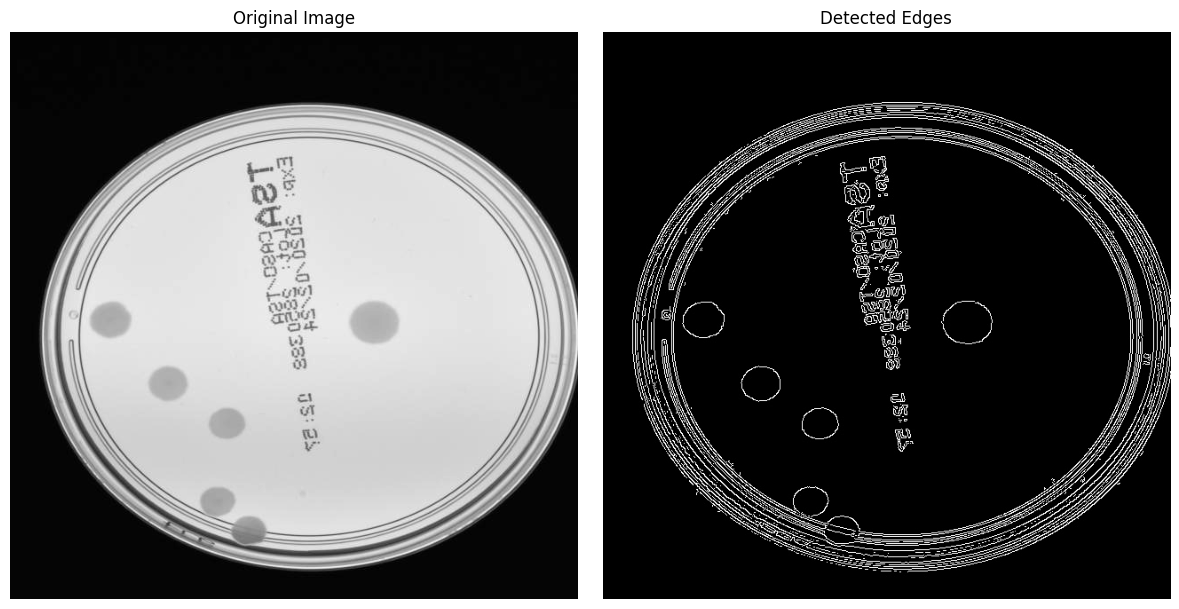

In [ ]:
# Original vs Canny Edge Detection
path_test = 'test/images/'
image_path = '5207_jpg.rf.dae377be8dbcae5373c24425715257e0.jpg'

img_orig = cv2.imread(path+path_test+image_path, cv2.IMREAD_GRAYSCALE)
img_canny = cv2.imread(path3+path_test+image_path, cv2.IMREAD_GRAYSCALE)

# Original Image vs Detected Edges
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img_orig, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(img_canny, cmap='gray')
ax[1].set_title('Detected Edges')
ax[1].axis('off')

plt.tight_layout()
plt.show()

# Segmentation Train-YOLO

In [ ]:
# Final Model-
config = {
    'imgsz':640,
    'plots':True,
    'epochs':50
}

In [ ]:
model = YOLO('yolov8n-seg.yaml')
model = YOLO('yolov8n-seg.pt')
model = YOLO('yolov8n-seg.yaml').load('yolov8n.pt')
results_canny = model.train(data=path3 + 'data.yaml', **config)
results= model.train(data=path + 'data.yaml',  **config)

# 경로를 저장합니다.
final_model = model.export()

In [ ]:
metrics = model.val(split='test')

In [ ]:
# model.predict('/content/Culture-Media-7/test/images/sp02_img07_jpg.rf.8b13f8ad94287517b034c2e205f62344.jpg', save=True)
model.predict('/content/Culture-Media-4/test/images/sp12_img08_jpg.rf.3645cb6004c034d19dc41b0426f06ecc.jpg', save=True, hide_labels=True, hide_conf=True)

# DBSCAN

In [ ]:
# DBSCAN 함수
def countCells(img_path, detection_model=YOLO('/content/runs/segment/train/weights/best.pt')):
    """배양배지 내에서 cell 계수 함수
    독립된 cell에 대해서만 계수하므로 겹친 cell들을 제외 시킵니다.

    이를 위해 DBSCAN 클러스터링 알고리즘을 사용합니다.
    epsilon은 배양배지 내 세포의 평균 크기입니다. epsilon내 세포가 있을 시 겹친 세포로 분류합니다.
    minPts는 2로 설정합니다. """
    # img_path: 실제 계수 할 이미지 경로
    # detection_model: 계수 작업을 위해 사용되는 segmentation model
    # 여기서는 이전 과정에서 학습시킨 model(YOLO segmentation)이 기본 모델입니다.
    res = detection_model(img_path)
    detections = np.array(res[0].boxes.xyxy.cpu().detach().numpy())

    centers = []
    for box in detections:
        center_x = (box[0] + box[2]) / 2
        center_y = (box[1] + box[3]) / 2
        centers.append([center_x, center_y])

    sizes = []  # epsilon 측정을 위한 크기를 저장할 빈 리스트

    for box in detections:
        x1, y1, x2, y2 = box  # 박스의 좌표 추출
        width = x2 - x1  # 박스의 너비 계산
        height = y2 - y1  # 박스의 높이 계산
        box_epsilon = (width + height) / 2  # epsilon 계산
        sizes.append(box_epsilon)  # 각 epsilon 들을 리스트에 저장

    total_epsilon = sum(sizes)  # 리스트에 있는 값들의 합계 계산
    average_epsilon = total_epsilon / len(centers)  # 합계를 리스트의 길이로 나누어 평균 계산
    centers = np.array(centers)

    # DBSCAN 군집화
    dbscan = DBSCAN(eps=average_epsilon, min_samples=2)  # eps와 min_samples는 조절이 필요할 수 있습니다.
    clusters = dbscan.fit_predict(centers)

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV에서는 BGR로 이미지를 불러오므로 RGB로 변환

     # 각 군집에 대한 색상 설정
    unique_clusters = sorted(set(clusters))
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_clusters)))
    color_mapping = {cluster: color for cluster, color in zip(unique_clusters, colors)}

    # 노이즈 (-1 군집)에 대한 색깔 고정 (검은색으로 설정)
    color_mapping[-1] = [0, 0, 0, 1]

    # 바운딩 박스 그리기
    for idx, (box, cluster) in enumerate(zip(detections, clusters)):
        color = color_mapping[cluster]
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), tuple([int(c * 255) for c in color[:-1]]), 1) # 굵기 1로 변경


    # 이미지 시각화
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    # clusters = dbscan.fit_predict(centers)
    cluster_counts = Counter(clusters)
    noise_counts = cluster_counts[-1]

    if noise_counts < 30:
        print(f"희석배수를 높여야 합니다. 현재 cell의 개수는 {noise_counts}개 입니다.")
    elif noise_counts > 300:
       print(f"희석배수를 낮춰야 합니다.")
    else:
       print(f"현재 cell의 개수는 {noise_counts}개 입니다.")

# 결과


image 1/1 /content/Culture-Media-4/test/images/sp12_img08_jpg.rf.3645cb6004c034d19dc41b0426f06ecc.jpg: 640x640 115 cells, 17.2ms
Speed: 3.1ms preprocess, 17.2ms inference, 40.5ms postprocess per image at shape (1, 3, 640, 640)


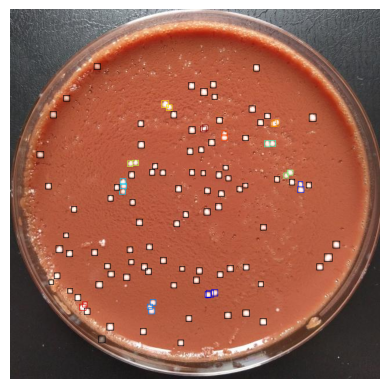

현재 cell의 개수는 88개 입니다.


In [ ]:
img_path = '/content/Culture-Media-4/test/images/sp12_img08_jpg.rf.3645cb6004c034d19dc41b0426f06ecc.jpg'
countCells(img_path, model)

# 실험 모델




In [ ]:
# model = YOLO('yolov8n-seg.yaml')
# model = YOLO('yolov8n-seg.pt')
# model = YOLO('yolov8n-seg.yaml').load('yolov8n.pt')
# res = model.train(data=path + 'data.yaml', epochs=15, **config)

In [ ]:
# metrics = model.val(split='test')

In [ ]:
# model = YOLO('yolov8n-seg.yaml')
# model = YOLO('yolov8n-seg.pt')
# model = YOLO('yolov8n-seg.yaml').load('yolov8n.pt')
# res = model.train(data=path + 'data.yaml', epochs=25, **config)

In [ ]:
# metrics = model.val(split='test')

In [ ]:
# model = YOLO('yolov8n-seg.yaml')
# model = YOLO('yolov8n-seg.pt')
# model = YOLO('yolov8n-seg.yaml').load('yolov8n.pt')
# res = model.train(data=path1 + 'data.yaml', epochs=10, **config)
# res = model.train(data=path + 'data.yaml', epochs=15, **config)

In [ ]:
# metrics = model.val(split='test')

In [ ]:
# model = YOLO('yolov8n-seg.yaml')
# model = YOLO('yolov8n-seg.pt')
# model = YOLO('yolov8n-seg.yaml').load('yolov8n.pt')
# res = model.train(data=path2 + 'data.yaml', epochs=10, **config)
# res = model.train(data=path + 'data.yaml', epochs=15, **config)

In [ ]:
# metrics = model.val(split='test')

In [ ]:
# model = YOLO('yolov8n-seg.yaml')
# model = YOLO('yolov8n-seg.pt')
# model = YOLO('yolov8n-seg.yaml').load('yolov8n.pt')
# res = model.train(data=path3 + 'data.yaml', epochs=10, **config)
# res = model.train(data=path + 'data.yaml', epochs=15, **config)

In [ ]:
# metrics = model.val(split='test')

In [ ]:
# model = YOLO('yolov8n-seg.yaml')
# model = YOLO('yolov8n-seg.pt')
# model = YOLO('yolov8n-seg.yaml').load('yolov8n.pt')
# res = model.train(data=path2 + 'data.yaml', epochs=10, **config)
# res = model.train(data=path + 'data.yaml', epochs=15, mask_ratio=6, **config)

In [ ]:
# metrics = model.val(split='test')

In [ ]:
# config_ = {
#     'imgsz':640,
#     'plots':True
# }

# model = YOLO('yolov8n-seg.yaml')
# model = YOLO('yolov8n-seg.pt')
# model = YOLO('yolov8n-seg.yaml').load('yolov8n.pt')
# res = model.train(data=path2 + 'data.yaml', epochs=10, **config_)
# res = model.train(data=path + 'data.yaml', epochs=15, mask_ratio=2, **config_)

In [ ]:
# metrics = model.val(split='test')